In [ ]:
!pip install transformers

In [ ]:
# Libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import time
import datetime
import random
import warnings
warnings.filterwarnings('ignore')

# Tokenize to add stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

# Data loading utility
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split

# Models
from torch import nn
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import logging
logging.set_verbosity_error()

# Training
from torch import optim

# Evaluation
from sklearn.metrics import accuracy_score, matthews_corrcoef

%matplotlib inline

# specify GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import pandas as pd
import yfinance as yf
import datetime

# Downloading FTSE100 stocks data
ftse100_stocks = yf.download("SBIN.NS JIOFIN.NS AXS ADANIPORTS.NS  PANW", start=datetime.datetime(2019, 1, 1),
                             end=datetime.datetime(2024,3,12), group_by='tickers')

# Save DataFrame to a pickle file
ftse100_stocks.to_pickle('aqr_stocks.pkl')

[*********************100%%**********************]  5 of 5 completed


In [ ]:
article_sentiments = pd.read_pickle('aqr_stocks.pkl')
article_sentiments

Ticker            PANW                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2019-01-01         NaN         NaN         NaN         NaN         NaN   
2019-01-02   61.680000   62.389999   60.639999   61.070000   61.070000   
2019-01-03   60.456669   60.959999   59.599998   59.900002   59.900002   
2019-01-04   60.686668   62.043331   60.540001   61.463333   61.463333   
2019-01-07   61.759998   62.666668   61.573334   62.450001   62.450001   
...                ...         ...         ...         ...         ...   
2024-03-05  295.890015  297.549988  284.679993  291.130005  291.130005   
2024-03-06  298.980011  300.000000  276.809998  278.859985  278.859985   
2024-03-07  280.000000  288.130005  277.750000  286.489990  286.489990   
2024-03-08  286.179993  288.450012  279.700012  280.200012  280.200012   
2024-03-11  278.299988  286.799988  277.609985  283.329987  283.329987   

Ticker                        AXS                                   ...  \
Price           Volume       Open       High        Low      Close  ...   
Date                                                                ...   
2019-01-01         NaN        NaN        NaN        NaN        NaN  ...   
2019-01-02   4432800.0  50.959999  51.470001  50.650002  51.070000  ...   
2019-01-03   3113700.0  50.779999  51.490002  50.759998  50.950001  ...   
2019-01-04   3366900.0  51.529999  53.419998  51.410000  53.320000  ...   
2019-01-07   3500400.0  53.000000  53.570000  52.709999  52.779999  ...   
...                ...        ...        ...        ...        ...  ...   
2024-03-05   7267100.0  60.230000  60.930000  60.230000  60.709999  ...   
2024-03-06  11691700.0  60.970001  61.360001  60.060001  60.680000  ...   
2024-03-07   8028300.0  60.680000  61.180000  60.520000  60.939999  ...   
2024-03-08   5732400.0  60.919998  61.610001  60.799999  61.180000  ...   
2024-03-11   4949100.0  61.029999  61.720001  61.029999  61.480000  ...   

Ticker         SBIN.NS                                     ADANIPORTS.NS  \
Price              Low       Close   Adj Close      Volume          Open   
Date                                                                       
2019-01-01  293.850006  299.600006  281.996826  11837127.0    386.299988   
2019-01-02  293.100006  293.899994  276.631744  25559853.0    388.000000   
2019-01-03  290.100006  291.100006  273.996216  17548347.0    382.399994   
2019-01-04  291.500000  297.649994  280.161377  19514041.0    378.649994   
2019-01-07  295.200012  296.299988  278.890686  14579399.0    385.000000   
...                ...         ...         ...         ...           ...   
2024-03-05  769.099976  783.950012  771.020264  18088847.0   1344.050049   
2024-03-06  772.900024  783.900024  770.971069  26710525.0   1342.699951   
2024-03-07  783.000000  788.049988  775.052612  15497868.0   1329.800049   
2024-03-08         NaN         NaN         NaN         NaN           NaN   
2024-03-11  770.549988  773.700012  760.939331  16778340.0   1331.000000   

Ticker                                                                     
Price              High          Low        Close    Adj Close     Volume  
Date                                                                       
2019-01-01   390.899994   384.049988   389.000000   375.101166  1233249.0  
2019-01-02   388.950012   378.000000   381.299988   367.676300  1506543.0  
2019-01-03   385.299988   376.600006   378.100006   364.590668  1902063.0  
2019-01-04   383.950012   375.850006   382.149994   368.495972  1669709.0  
2019-01-07   386.950012   379.350006   381.649994   368.013824  1260331.0  
...                 ...          ...          ...          ...        ...  
2024-03-05  1354.949951  1334.000000  1338.300049  1332.582642  1815438.0  
2024-03-06  1344.599976  1304.000000  1324.800049  1319.140259  2758443.0  
2024-03-07 

In [ ]:
article_sentiments.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1347 entries, 2019-01-01 to 2024-03-11
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (PANW, Open)                1306 non-null   float64
 1   (PANW, High)                1306 non-null   float64
 2   (PANW, Low)                 1306 non-null   float64
 3   (PANW, Close)               1306 non-null   float64
 4   (PANW, Adj Close)           1306 non-null   float64
 5   (PANW, Volume)              1306 non-null   float64
 6   (AXS, Open)                 1306 non-null   float64
 7   (AXS, High)                 1306 non-null   float64
 8   (AXS, Low)                  1306 non-null   float64
 9   (AXS, Close)                1306 non-null   float64
 10  (AXS, Adj Close)            1306 non-null   float64
 11  (AXS, Volume)               1306 non-null   float64
 12  (JIOFIN.NS, Open)           136 non-null    float64
 13  (JIOFIN.NS, Hig

In [ ]:
!pip install pandas
import pandas as pd
article_sentiments = pd.DataFrame({'Label': [0, 1, 0, 1, 1]})

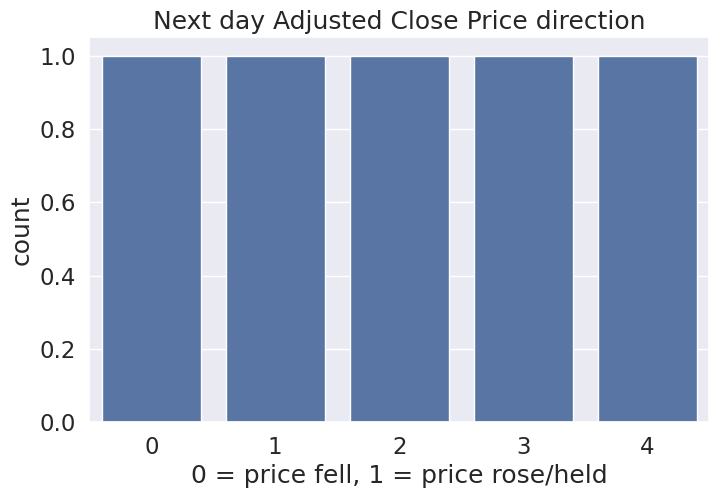

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (8,5)
sns.countplot(article_sentiments.Label)
plt.title('Next day Adjusted Close Price direction')
plt.xlabel('0 = price fell, 1 = price rose/held');

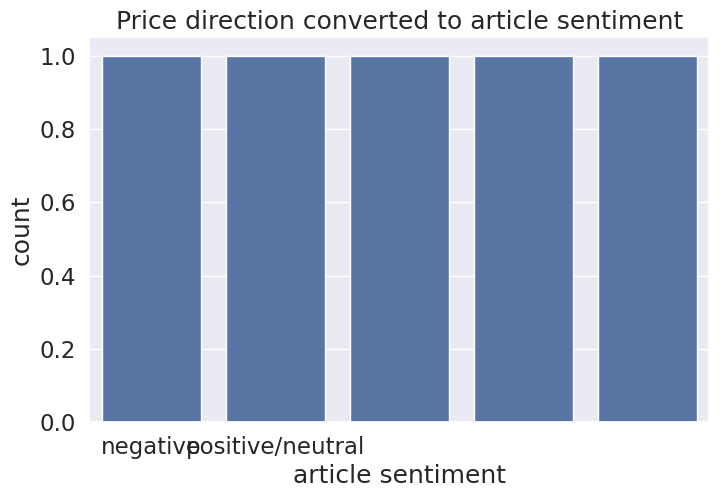

In [ ]:
# Plot showing Adjusted Close prices converted to sentiment

def to_sentiment(label):
  label = int(label)
  if label == 0:
    return 0
  else:
    return 1

article_sentiments['sentiment'] = article_sentiments.Label.apply(to_sentiment)

class_names = ['negative', 'positive/neutral']

# Plot the counts of observations in each categorical bin
ax = sns.countplot(article_sentiments.sentiment)

# Label the plot
plt.title('Price direction converted to article sentiment')
plt.xlabel('article sentiment')
ax.set_xticklabels(class_names);

In [ ]:
pip install nltk Googlenews newspaper3k wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13538 sha256=8288b1cc83166ea3f1a5ba8994b73f0bad033c1c9e1b8123926b5980ccb74096
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3340 sha256=f7181d6111716554b2014626fc7ca751db620eb5092e0ef8f0212b495bacf5a3
  St

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from wordcloud import WordCloud, STOPWORDS

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
now = dt.date.today()
now = now.strftime('%m-%d-%Y')
yesterday = dt.date.today() - dt.timedelta(days = 1)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 10


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
company_name = input("Please provide the name of the Company or a Ticker: ")
if company_name != '':
    print(f'Searching for and analyzing {company_name}, Please be patient, it might take a while...')
    googlenews = GoogleNews(start=yesterday,end=now)
    googlenews.search(company_name)
    result = googlenews.result()
    df = pd.DataFrame(result)
    print(df)


Please provide the name of the Company or a Ticker: amzn
Searching for and analyzing amzn, Please be patient, it might take a while...
                                               title                  media  \
0  Amazon Plans to Brick All Existing $2350 Astro...            ExtremeTech   
1  Get a $200 Amazon Gift Card in Time for Prime Day                   CNET   
2  How Businesses Plan to Drive Serious Sales Thi...                Inc.com   
3     Amazon vows to open RI fulfillment center soon  The Business Journals   
4  Amazon Debuts Updated Echo Spot as Prime Day A...             PYMNTS.com   
5  8 Ultra-Reliable Beauty Products I Just Have T...              Brit + Co   
6  Amazon’s Coventry workers begin voting in hist...           The Guardian   
7  Jeff Bezos' advice from years ago is still rel...       Business Insider   
8  Zepto CEO: If you want to build a business big...         Times of India   
9  Circle K's Head of Private Label Moves to Amaz...         CSP Daily News

In [ ]:
try:
    list =[]
    for i in df.index:
        dict = {}
        article = Article(df['link'][i],config=config) #providing the link
        try:
          article.download()
          article.parse()
          article.nlp()
        except:
           pass
        dict['Date']=df['date'][i]
        dict['Media']=df['media'][i]
        dict['Title']=article.title
        dict['Article']=article.text
        dict['Summary']=article.summary
        dict['Key_words']=article.keywords
        list.append(dict)
    check_empty = not any(list)
    # print(check_empty)
    if check_empty == False:
      news_df=pd.DataFrame(list) #creating dataframe
      print(news_df)

except Exception as e:
    #exception handling
    print("exception occurred:" + str(e))
    print('Looks like, there is some error in retrieving the data, Please try again or try with a different ticker.' )


            Date                  Media  \
0  2 minutes ago            ExtremeTech   
1  6 minutes ago                   CNET   
2  9 minutes ago                Inc.com   
3     1 hour ago  The Business Journals   
4     1 hour ago             PYMNTS.com   
5    2 hours ago              Brit + Co   
6    2 hours ago           The Guardian   
7    2 hours ago       Business Insider   
8    2 hours ago         Times of India   
9    3 hours ago         CSP Daily News   

                                               Title  \
0                                                      
1                                                      
2                                                      
3                                                      
4                                                      
5                                                      
6                                                      
7  Jeff Bezos shared a key piece of business advi...   
8                     

Positive Sentiment: 2.00
Neutral Sentiment: 8.00
Negative Sentiment: 0.00


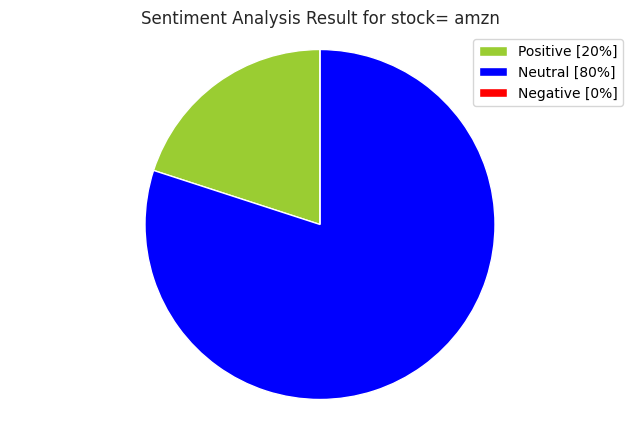

Wordcloud for amzn


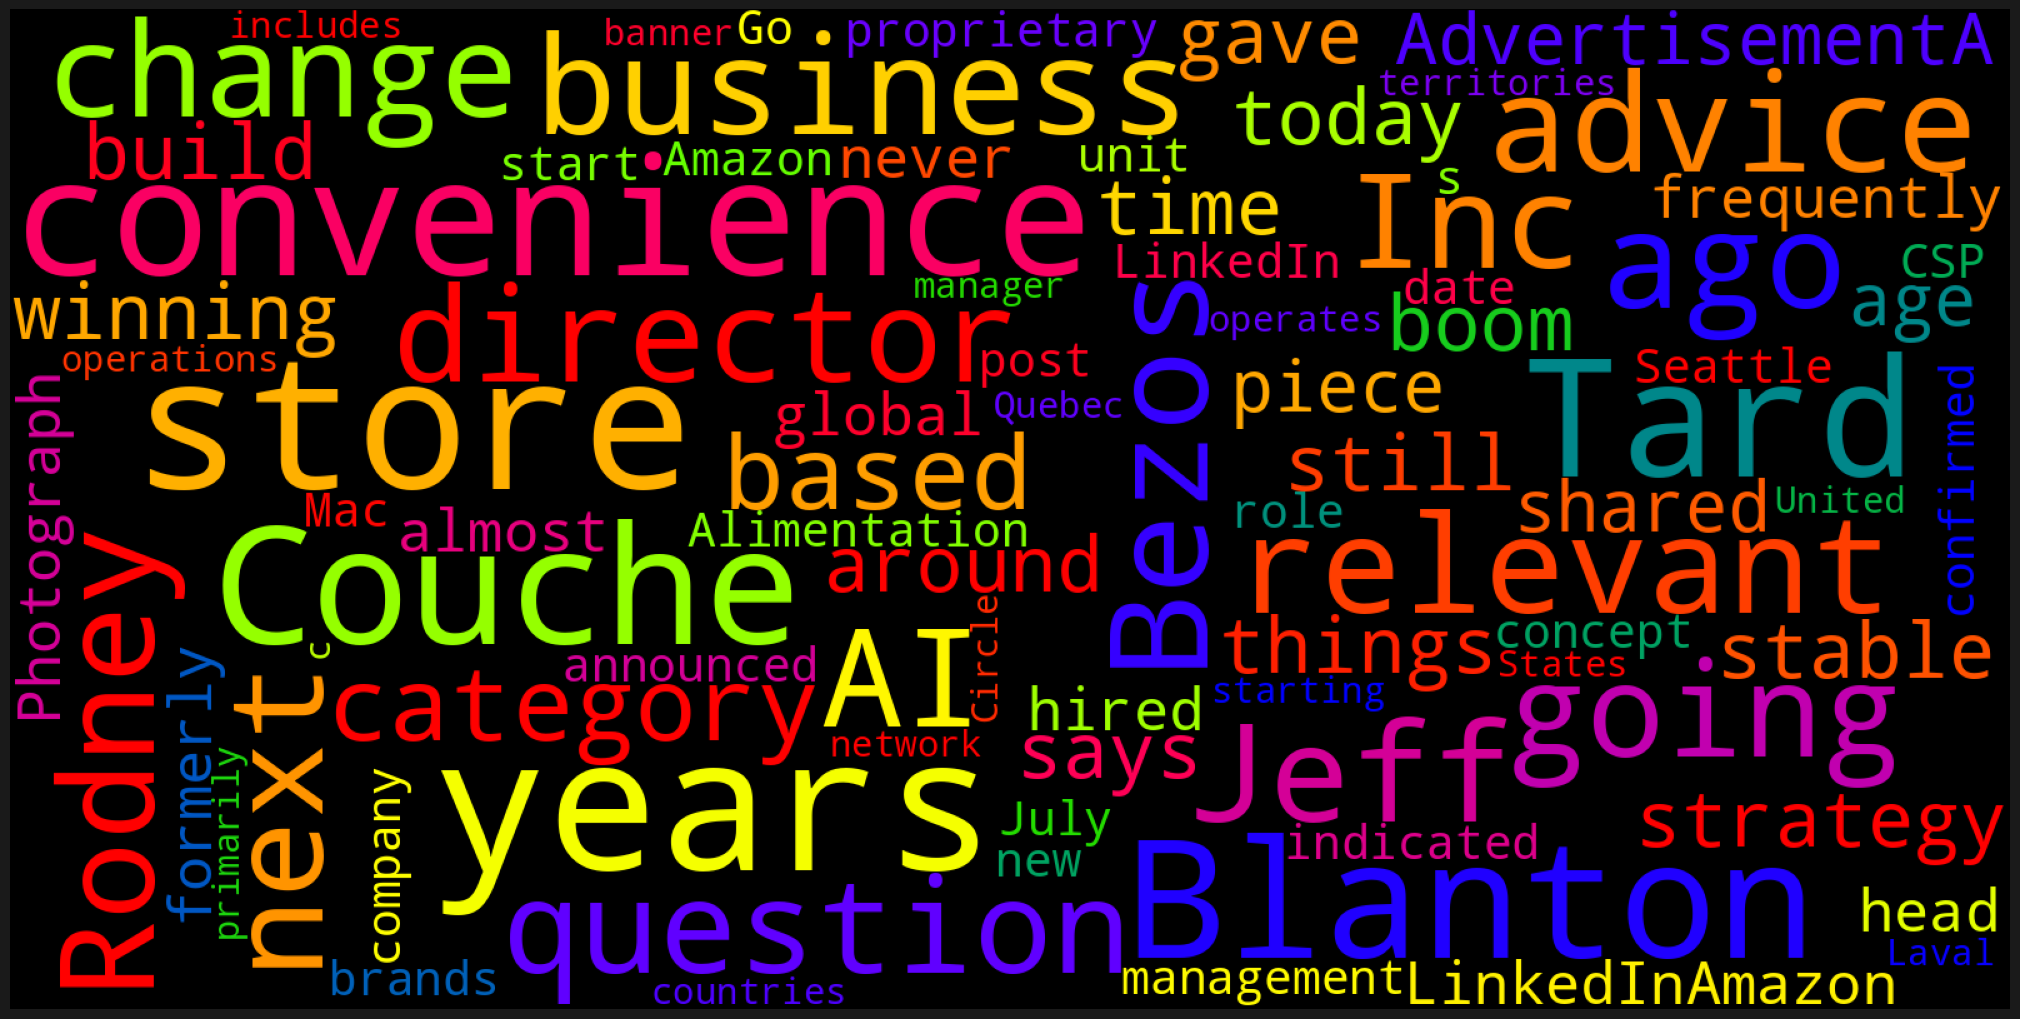

In [ ]:

def percentage(part,whole):
    return 100 * float(part)/float(whole)


positive = 0
negative = 0
neutral = 0

news_list = []
neutral_list = []
negative_list = []
positive_list = []


for news in news_df['Summary']:
    news_list.append(news)
    analyzer = SentimentIntensityAnalyzer().polarity_scores(news)
    neg = analyzer['neg']
    neu = analyzer['neu']
    pos = analyzer['pos']
    comp = analyzer['compound']

    if neg > pos:
        negative_list.append(news)
        negative += 1
    elif pos > neg:
        positive_list.append(news)
        positive += 1
    elif pos == neg:
        neutral_list.append(news)
        neutral += 1

positive = percentage(positive, len(news_df))
negative = percentage(negative, len(news_df))
neutral = percentage(neutral, len(news_df))


news_list = pd.DataFrame(news_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)

print("Positive Sentiment:", '%.2f' % len(positive_list), end='\n')
print("Neutral Sentiment:", '%.2f' % len(neutral_list), end='\n')
print("Negative Sentiment:", '%.2f' % len(negative_list), end='\n')

#Creating PieCart
labels = ['Positive ['+str(round(positive))+'%]' , 'Neutral ['+str(round(neutral))+'%]','Negative ['+str(round(negative))+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for stock= "+company_name+"" )
plt.axis('equal')
plt.show()

# Word cloud visualization
def word_cloud(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([nws for nws in text])
    wordCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=150,colormap='prism').generate(allWords)
    fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()

print('Wordcloud for ' + company_name)
word_cloud(news_df['Summary'].values)
